<h1 align="center">TAREA 1: Sistemas Recomendadores </h1>

<h3 align="left">Integrantes:</h3>
<p align="left">- Martín Jara</p>
<p align="left">- Joaquín Fuentealba</p>

In [24]:
!pip3 install implicit --upgrade


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import implicit
import scipy.sparse as sparse

In [5]:
articles = 'articles.xlsx'
customers = 'customers.xlsx'
transaction_val = 'transactions_val.xlsx'
users_test = 'users_test.xlsx'
transactions_train = 'transactions_train.csv'

In [6]:
df_articles = pd.read_excel(articles)
df_customers = pd.read_excel(customers)
# df_transaction_val = pd.read_excel(transaction_val)
# df_users_test = pd.read_excel(users_test)
df_transaction_train = pd.read_csv(transactions_train)

# Actividad 1: Análisis exploratorio

## Grafique la distribucion del numero de compras por usuario, identifique los ids de los 10 usuarios mas activos en el dataset. Comente la forma de la distribucion obtenida y que porcentaje de las interacciones han sido hechas por estos 10 usuarios.

In [7]:
agrupado_compras_por_usuario = df_transaction_train.groupby(['customer_id']).size().reset_index(name='compras_por_usuario')
agrupado_compras_por_usuario = agrupado_compras_por_usuario.sort_values(by='compras_por_usuario', ascending=False)

### 10 usuarios mas activos:

In [8]:
agrupado_compras_por_usuario.head(10)

,customer_id,compras_por_usuario
29300,a65f77281a528bf5c1e9f270141d601d116e1df33bf9df...,1346
23387,84c34f4f564db1f437943c77af41f83bf6fd7c01701cbb...,950
40316,e55d5ddb3a0c3fb1b4df8edbf526ba12989ab2a852c727...,910
8155,2df54f0d0653811fe06479c93905f3e6ecc6d07edf39d8...,875
28011,9f12a01e2982f70a820b5dd61528bf769b94c5c5e43b23...,789
33036,bbebb44478948f5052c3f4c5dc04f08653e7938886a856...,740
37241,d3b5f70ec21ad1718cf4951445e97007de0d4e85c39ea9...,724
30502,ad3090d52d11671ffb43bfaa85e3620eff669e8c92c911...,670
244,0152d53f51444891ea07013fd1fb8325415bb09bb6798a...,664
315,01a4717d38b651e46dda7f1ab8d1494af2682a847fa9a5...,651


Porcentaje de interacciones hechas por los 10 usuarios mas activos:

In [9]:
percentage_top10_user = (agrupado_compras_por_usuario.head(10)['compras_por_usuario'].sum()/agrupado_compras_por_usuario["compras_por_usuario"].sum())*100
print(f"{percentage_top10_user:.3f} %")

0.631 %


### Distribución del número de compras por usuario

In [10]:
cantidad_usuario_por_numero_de_compras = agrupado_compras_por_usuario.groupby(['compras_por_usuario']).size().reset_index(name='cantidad_usuario_por_compras')
cantidad_usuario_por_numero_de_compras['percentage'] = cantidad_usuario_por_numero_de_compras['cantidad_usuario_por_compras'] / cantidad_usuario_por_numero_de_compras['cantidad_usuario_por_compras'].sum() * 100
cantidad_usuario_por_numero_de_compras

,compras_por_usuario,cantidad_usuario_por_compras,percentage
0,2,2851,6.335556
1,3,2767,6.148889
2,4,2814,6.253333
3,5,3052,6.782222
4,6,2860,6.355556
...,...,...,...
400,789,1,0.002222
401,875,1,0.002222
402,910,1,0.002222
403,950,1,0.002222


In [11]:
def rango_compras_por_usuario(compras_por_usuario):
    if compras_por_usuario == 2:
        return 2
    elif compras_por_usuario == 3:
        return 3
    elif compras_por_usuario == 4:
        return 4
    elif compras_por_usuario == 5:
        return 5
    elif compras_por_usuario == 6:
        return 6
    elif compras_por_usuario == 7:
        return 7
    elif compras_por_usuario == 8:
        return 8
    elif compras_por_usuario == 9:
        return 9
    elif compras_por_usuario == 1:
        return 1
    else:
        return 10
    
cantidad_usuario_por_numero_de_compras['rango'] = cantidad_usuario_por_numero_de_compras['compras_por_usuario'].apply(rango_compras_por_usuario)    

In [12]:
cantidad_usuario_por_numero_de_compras_agrupado = cantidad_usuario_por_numero_de_compras.groupby(['rango']).sum().reset_index()

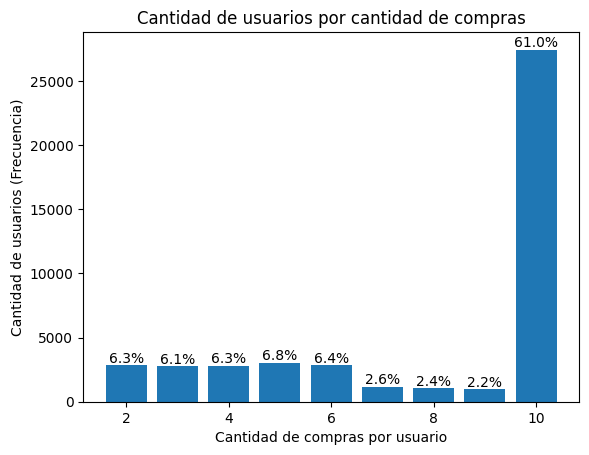

In [13]:
rango = cantidad_usuario_por_numero_de_compras_agrupado['rango']
cantidad_usuarios = cantidad_usuario_por_numero_de_compras_agrupado['cantidad_usuario_por_compras']
porcentaje = cantidad_usuario_por_numero_de_compras_agrupado['percentage']

plt.bar(rango, cantidad_usuarios)
plt.xlabel('Cantidad de compras por usuario')
plt.ylabel('Cantidad de usuarios (Frecuencia)')
plt.title('Cantidad de usuarios por cantidad de compras')

for i in range(len(rango)):
    plt.text(rango[i], cantidad_usuarios[i] + 200, f'{round(porcentaje[i], 1)}%', ha='center')

plt.show()


## Grafique la distribucion de interacciones por producto. Identifique los nombres y ids de los 10 productos que han sido mas comprados. Comente la forma de la distribucion y que porcentaje de las interacciones han sido sobre estos 10 productos.


In [14]:
df_transaction_train.head(10)

,Unnamed: 0,t_dat,customer_id,article_id,price,sales_channel_id
0,0,2018-11-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,655265001,0.025407,2
1,1,2018-11-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,537688014,0.050831,2
2,2,2019-03-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,698877002,0.042356,2
3,3,2019-03-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,382127027,0.032186,2
4,4,2019-03-28,1f293f035403ce2d1ff0cdb23cc3faf8b1c2ad04dbedbe...,610776001,0.008458,2
5,5,2019-05-17,b4ba419fd5afc5eb274ab3ae1638a51a2e916b4deb0a5c...,647826001,0.016932,2
6,6,2019-10-03,b4ba419fd5afc5eb274ab3ae1638a51a2e916b4deb0a5c...,754697001,0.017610,2
7,7,2019-10-03,b4ba419fd5afc5eb274ab3ae1638a51a2e916b4deb0a5c...,754697001,0.017610,2
8,8,2019-09-03,1a1563c28f0d8781ad87f76e0a5af0485003e350f541dd...,801673004,0.016932,2
9,9,2019-09-03,1a1563c28f0d8781ad87f76e0a5af0485003e350f541dd...,448509001,0.042356,2


In [15]:
agrupado_compras_item = df_transaction_train.groupby(['article_id']).size().reset_index(name='compras_por_item')
agrupado_compras_item = agrupado_compras_item.sort_values(by='compras_por_item', ascending=False)

### 10 productos más comprados:

In [16]:
top_10_items = agrupado_compras_item.head(10)
top_10_items = pd.merge(top_10_items, df_articles, on='article_id', how='left')
top_10_items = top_10_items[['article_id', 'prod_name', 'compras_por_item']]
top_10_items

,article_id,prod_name,compras_por_item
0,706016001,Jade HW Skinny Denim TRS,1978
1,706016002,Jade HW Skinny Denim TRS,1357
2,610776002,Tilly (1),1302
3,372860001,7p Basic Shaftless,1225
4,759871002,Tilda tank,1010
5,399223001,Curvy Jeggings HW Ankle,991
6,464297007,Greta Thong Mynta Low 3p,920
7,562245001,Luna skinny RW,899
8,562245046,Luna skinny RW,849
9,372860002,7p Basic Shaftless,849


Porcentaje de interacciones hechas sobre los 10 productos más comprados:

In [17]:
percentage_top10_item = (agrupado_compras_item.head(10)['compras_por_item'].sum()/agrupado_compras_item["compras_por_item"].sum())*100
print(f"{percentage_top10_item:.3f} %")

0.863 %


### Distribución del número de interacciones por producto

In [18]:
agrupado_compras_item

,article_id,compras_por_item
36789,706016001,1978
36790,706016002,1357
14906,610776002,1302
1174,372860001,1225
49637,759871002,1010
...,...,...
61591,823332003,1
61592,823334001,1
28007,673806004,1
28006,673805001,1


In [19]:
cantidad_item_por_numero_de_compras = agrupado_compras_item.groupby(['compras_por_item']).size().reset_index(name='cantidad_item_por_compras')
cantidad_item_por_numero_de_compras['percentage'] = cantidad_item_por_numero_de_compras['cantidad_item_por_compras'] / cantidad_item_por_numero_de_compras['cantidad_item_por_compras'].sum() * 100
cantidad_item_por_numero_de_compras

,compras_por_item,cantidad_item_por_compras,percentage
0,1,13139,17.978927
1,2,8086,11.064587
2,3,5706,7.807882
3,4,4294,5.875753
4,5,3429,4.692118
...,...,...,...
427,1010,1,0.001368
428,1225,1,0.001368
429,1302,1,0.001368
430,1357,1,0.001368


In [20]:
cantidad_item_por_numero_de_compras['rango'] = cantidad_item_por_numero_de_compras['compras_por_item'].apply(rango_compras_por_usuario)
cantidad_item_por_numero_de_compras_agrupado = cantidad_item_por_numero_de_compras.groupby(['rango']).sum().reset_index()

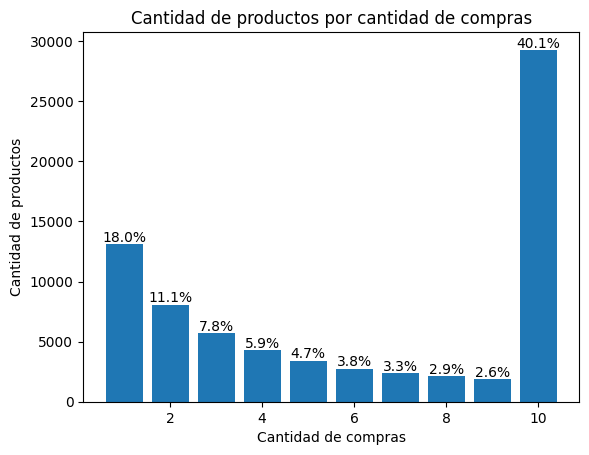

In [21]:
rango_item = cantidad_item_por_numero_de_compras_agrupado['rango']
cantidad_item = cantidad_item_por_numero_de_compras_agrupado['cantidad_item_por_compras']
porcentaje_item = cantidad_item_por_numero_de_compras_agrupado['percentage']

plt.bar(rango_item, cantidad_item)
plt.xlabel('Cantidad de compras')
plt.ylabel('Cantidad de productos')
plt.title('Cantidad de productos por cantidad de compras')

for i in range(len(rango_item)):
    plt.text(rango_item[i], cantidad_item[i] + 200, f'{round(porcentaje_item[i], 1)}%', ha='center')

plt.show()

## Genere una tabla resumen con el numero de usuarios distintos, el numero de productos distintos, promedio y desviacion estandar de productos por usuario, promedio y desviacion estandar de usuarios por productos y densidad del conjunto de datos (o sparsity)en cuanto a compras.

### Tabla resumen

In [22]:
usuarios_distintos = df_customers['customer_id'].nunique()
productos_distintos = df_articles['article_id'].nunique()
promedio_productos_por_usuario = df_transaction_train.groupby(['customer_id'])['article_id'].count().mean()
desviacion_estandar_productos_por_usuario = df_transaction_train.groupby(['customer_id'])['article_id'].count().std()
promedio_usuarios_por_producto = df_transaction_train.groupby(['article_id'])['customer_id'].count().mean()
desviacion_estandar_usuarios_por_producto = df_transaction_train.groupby(['article_id'])['customer_id'].count().std()
sparsity = 1 - (df_transaction_train.shape[0] / (usuarios_distintos * productos_distintos))

In [23]:
print("+-------------------------------------------+------------------------+")
print("| Datos                                     | Valor                  |")
print("+-------------------------------------------+------------------------+")
print(f"| Usuarios distintos                        | {usuarios_distintos:<23}|")
print(f"| Productos distintos                       | {productos_distintos:<23}|")
print(f"| Promedio productos por usuario            | {promedio_productos_por_usuario:<23}|")
print(f"| Desviación estándar productos por usuario | {desviacion_estandar_productos_por_usuario:<23}|")
print(f"| Promedio usuarios por producto            | {promedio_usuarios_por_producto:<23}|")
print(f"| Desviación estándar usuarios por producto | {desviacion_estandar_usuarios_por_producto:<23}|")
print(f"| Sparsity                                  | {sparsity:<23}|")
print("+-------------------------------------------+------------------------+")


+-------------------------------------------+------------------------+
| Datos                                     | Valor                  |
+-------------------------------------------+------------------------+
| Usuarios distintos                        | 45000                  |
| Productos distintos                       | 77650                  |
| Promedio productos por usuario            | 29.30002222222222      |
| Desviación estándar productos por usuario | 44.93946050091238      |
| Promedio usuarios por producto            | 18.04188560481664      |
| Desviación estándar usuarios por producto | 38.017470006210154     |
| Sparsity                                  | 0.9996226655219289     |
+-------------------------------------------+------------------------+


# Actividad 2: Recomendación no personalizada

# Actividad 3: Recomendación basada en feedback implícito

In [30]:
user_items = {}
itemset = set()

for row in df_transaction_train.itertuples():
    if row[1] not in user_items:
        user_items[row[1]] = []
        
    user_items[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))

sparse_matrix = np.zeros((len(user_items), len(itemset)))

for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique=True).astype(int)
    
matrix = sparse.csr_matrix(sparse_matrix.T)

### Factorización matricial optimizada por ALS

In [31]:
model_als = implicit.als.AlternatingLeastSquares(factors=100, iterations=10, use_gpu=False)
model_als.fit(matrix)

c:\Users\marti\AppData\Local\Programs\Python\Python310\lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/10 [00:00<?, ?it/s]

### Factorización matricial optimizada por BPR